# 台風

この節では台風に関する解析を行います。
台風の中心位置を求め，軸対称成分を計算します。
二種類の内挿方法についても学びます。

In [1]:
import numpy as np
import xarray as xr
from metpy.units import units
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## 台風の中心位置

ここでもNCEP再解析を利用します。
台風の解析には解像度が粗いのですが，サイズが小さいNetCDF形式で扱いやすく，内挿が有効です。

東日本を中心に大きな被害をもたらした令和元年東日本台風（2019年台風第19号，Hagibis）{cite}`Nakashita-Enomoto:2021`について調べてみましょう。
2019年の海面気圧のデータを取得します。

In [2]:
dods = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep"
yyyy = 2019
ds = xr.open_dataset(f"{dods}/slp.{yyyy}.nc")

c:\users\subhi\appdata\local\programs\python\python39\lib\site-packages\xarray\conventions.py:512: SerializationWarning: variable 'slp' has multiple fill values {-99, 32767}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Hagibisの最盛期に着目し，10月9日，日本の南海上を切り出します。
このデータは00 UTCと12 UTCの平均です。

In [4]:
yyyymmdd = f"{yyyy}-10-09"
lat0, lat1 = 60, 0
lon0, lon1 = 110, 170
slp = ds.slp.loc[yyyymmdd, lat0:lat1, lon0:lon1]

`slp`や`slp.plot()`で内容を確認しましょう。

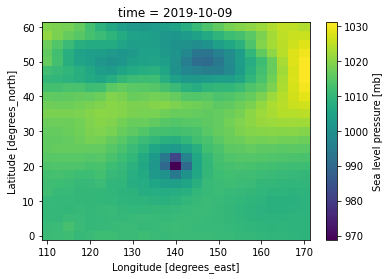

In [5]:
slp.plot()

ECMWFでは，熱帯低気圧の中心を850 hPaの渦度や指向流を用いた高度なアルゴリズム{cite}`van_der_Grijn:2002`で追跡しています。温帯低気圧は非軸対称性が強く，軸が傾いた傾圧構造をしており，高度な手法{cite}`Inatsu:2009`が考案されています。ここでは，著者が[pytrack](https://github.com/tenomoto/pytrack)で用いた海面気圧の極小値を見つける単純な方法を説明します。

極小値は[`scipy.ndimage.filters.minimum_filter()`](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.ndimage.minimum_filter.html#scipy.ndimage.minimum_filter)を使って見つけます。
後で用いる2次内挿と整合するように$3\times 3$の格子での極小を探します。
領域を切り出しているので`mode`は緯度・経度どちらの次元も端の値を延長する`nearest`を使います。

In [6]:
from scipy import ndimage

loc_min = np.where(ndimage.filters.minimum_filter(slp, size=(3,3), mode=('nearest', 'nearest')) == slp)

気象庁の[台風位置表](https://www.data.jma.go.jp/yoho/typhoon/position_table/index.html)，2019年[第19号](https://www.data.jma.go.jp/yoho/data/typhoon/T1919.pdf)によると，10月9日00 UTC（日本時9時），06 UTC（日本時15時），12 UTC（日本時21時）における中心位置はそれぞれ東経140.4度，北緯19.8度，東経140.0度, 北緯20.6度，東経139.6度，北緯21.2度とされています。
推定位置として$\lambda=140^\circ, \phi=20^\circ$を与えて，求めた極小値との大円距離$d=a\alpha$（$a$は地球半径）

$$
\cos \alpha = \sin\theta_0 \sin\theta + \cos\theta_0 \cos\theta \cos(\lambda-\lambda_0)
$$

を計算します。
単位球において2点がなす中心角$\alpha$の大きさで比較しても大小は変わらないので，地球半径は省略しています。


In [7]:
hres = 2.5
lon = slp.lon.data
lat = slp.lat.data
lon0, lat0 = 140, 20
dx = np.deg2rad(lon[loc_min[1]] - lon0)
y1 = np.deg2rad(lat[loc_min[0]])
y0 = np.deg2rad(lat0)
d = np.arccos(np.sin(y0) * np.sin(y1) + np.cos(y0) * np.cos(y1) * np.cos(dx))
n = np.argmin(d)
jmin, imin = loc_min[0][n], loc_min[1][n]

与えた経度と緯度に最も近い極小の場所が特定されました。
この点と隣接する周りの点，計9点を1次元の配列に格納します。
中心が0，左下隅から反時計回りに格納します。

In [8]:
f = np.zeros(9)
f[0] = slp[jmin, imin]
f[1] = slp[jmin-1, imin-1]
f[2] = slp[jmin-1, imin]
f[3] = slp[jmin-1, imin+1]
f[4] = slp[jmin, imin+1]
f[5] = slp[jmin+1, imin+1]
f[6] = slp[jmin+1, imin]
f[7] = slp[jmin+1, imin-1]
f[8] = slp[jmin, imin-1]

$f$を$x, y$の2次函数とします。

$$
f(x, y) = c_0 + c_1x + c_2y + c_3xy + c_4x^2 + c_5y^2 + c_6x^2y + c_7xy^2 + c_8x^2y^2
$$

2次函数が極値をとるための必要条件はその勾配が0となることです。
格子点においては，$x_0, y_0$で$f(x_0, y_0)$が極小であるとします。
$f(x, y)$の極小は格子点上にくるとは限りません。
$f(x, y)$の極小が$x_0+\Delta x, y_0+\Delta y$であるとして，$x_0, y_0$の周りでTaylor展開すると

$$
f(x, y) = f(x_0, y_0) + f_x\Delta x + f_y\Delta y + \frac{1}{2}f_{xx}(\Delta x)^2 +  \frac{1}{2}f_{yy}(\Delta x)^2+f_{xy}\Delta x\Delta y
$$

となります。

$$
\begin{align}
\mathbf{b} &= -\begin{bmatrix}f_x\\f_y\end{bmatrix},\\
\mathbf{A} &= \begin{bmatrix}f_{xx} & f_{xy} \\ f_{xy} & f_{yy}\end{bmatrix},\\
\mathbf{x} &= \begin{bmatrix}\Delta x\\ \Delta y\end{bmatrix}
\end{align}
$$

とおくと，

$$
\begin{align}
f(x, y) &= f(x_0, y_0) - \mathbf{b}^T\mathbf{x} + \frac{1}{2}\mathbf{x}^T\mathbf{A}\mathbf{x}, \\
\nabla f &= \mathbf{A}\mathbf{x} - \mathbf{b} = 0, \\
\mathbf{x} &= \mathbf{A}^{-1}\mathbf{b}
\end{align}
$$

と書けます。

$d \equiv f_{xx}f_{yy}-f_{xy}^2 \ne 0$のとき

$$
\mathbf{A}^{-1} = \frac{1}{d}\begin{pmatrix}f_{yy}&-f_{xy}\\-f_{xy}&f_{xx}\end{pmatrix}
$$

となるので$\Delta x, \Delta y$が求まり極値を決定することができます。

In [9]:
c = np.zeros_like(f)
c[0] = f[0]
c[1] = f[4] - f[8]
c[2] = f[6] - f[2]
c[3] = f[1] - f[3] + f[5] - f[7]
c[4] = 2.0 * (f[4] + f[8] - 2.0 * f[0])
c[5] = 2.0 * (f[2] + f[6] - 2.0 * f[0])
c[6] = 2.0 * (f[5] + f[7] - f[1] - f[3] - 2.0 * (f[6] - f[2]))
c[7] = 2.0 * (f[3] + f[5] - f[1] - f[7] - 2.0 * (f[4] - f[8]))
c[8] = 4.0 * (f[1] + f[3] + f[5] + f[7] - 2.0 * (f[2] + f[4] + f[6] + f[8]) + 4.0 * f[0])
fx, fy, fxy = c[1], c[2], c[3]
fxx, fyy = 2.0 * c[4], 2.0 * c[5]
d = fxx * fyy - fxy * fxy

In [10]:
x = ( fyy * (-fx) + (-fxy) * (-fy)) / d
y = (-fxy * (-fx) +   fxx  * (-fy)) / d
slpmin = c[0] + c[1] * x + c[2] * y + c[3] * x * y \
    + c[4] * x * x + c[5] * y * y + c[6] * x * x * y \
    + c[7] * x * y * y + c[8] * x * x * y * y

In [11]:
lonmin = lon[imin] + x * hres
latmin = lat[jmin] - y * hres
print(f"{lonmin:7.2f}, {latmin:6.2f}")

 139.99,  20.20


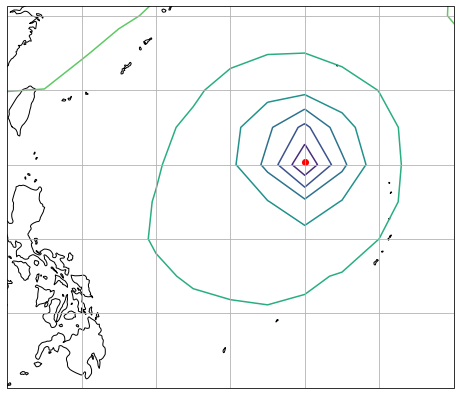

In [12]:
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.contour(slp.lon, slp.lat, slp, transform=ccrs.PlateCarree())
ax.scatter(lonmin, latmin, c="red", transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
ax.set_extent([120, 150, 5, 30])

経度方向は与えた値とあまり変わりませんが，北に少しずれました。
気象庁の位置表の値とも整合しています。

## 台風の軸対称構造

最盛期の台風は中心軸の周りに対称的な構造をしています。
特定した中心位置の周りに同心円状にデータを内挿し，軸対称構造を確認しましょう。
ここでは座標回転を用いる方法{cite}`Enomoto:2019,Nakashita-Enomoto:2021`を用います。

この方法は著者の研究室のウェブサイト「[北極に台風を置く](https://www.dpac.dpri.kyoto-u.ac.jp/2018/02/26/tc-at-np.html)」でも説明していますが，手順は以下の通りです。

1. 台風中心が北極にあると考えて，その周りに経度緯度座標を設定します。便宜的に北極座標と呼びます。
2. 北極座標をデカルト座標に直します。
2. 軸回転により北極を台風中心の位置に移動します。
3. デカルト座標を緯度経度に直して内挿を行います。

台風中心を$\lambda_\mathrm{c}, \phi_\mathrm{c}$とすると，回転行列は以下のように表されます。

$$
\begin{pmatrix}
\cos\lambda_\mathrm{c}\sin\phi_\mathrm{c} & -\sin\lambda_\mathrm{c} & \cos\lambda_\mathrm{c}\cos\phi_\mathrm{c}\\
\sin\lambda_\mathrm{c}\sin\phi_\mathrm{c} &\cos\lambda_\mathrm{c} & \sin\lambda_\mathrm{c}\cos\phi_\mathrm{c} \\
-\cos\phi_\mathrm{c} & 0 & \sin\phi_\mathrm{c}
\end{pmatrix}
$$

北極座標では，北極に台風中心がありその周りを緯度円が囲んでいます。
緯度円に沿って東西平均すると，軸対称成分が得られます。
軸対称成分を差し引くと，非軸対称成分になります。

[`numpy.meshgrid()`](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html)は座標軸から，座標配列を生成します。既定では，座標軸の順（`xy`）なので注意が必要です。
2次元の場合`x`は`x`方向に並んだ行ベクトルとして反復され，`y`は`y`方向に並んだ列ベクトルとして反復されます。
配列の添え字の順序とは逆順です。
matplotlibとの整合性を考えて既定が決まっているようです。
添え字の順序にしたいときは`indexing="ij"`とします。

In [22]:
x = 1, 2, 3
y = 10, 20
X, Y = np.meshgrid(x, y)
print(X)
print(Y)

[[1 2 3]
 [1 2 3]]
[[10 10 10]
 [20 20 20]]


In [14]:
plon = np.deg2rad(np.arange(0, 360, 2))
plat = np.deg2rad(np.arange(80, 90.1, 1))
PLON, PLAT = np.meshgrid(plon, plat)
PLON = PLON.flatten()
PLAT = PLAT.flatten()

経度・緯度をデカルト座標にするには以下を計算します。

$$
\begin{align}
x &= \cos\lambda\cos\phi \\
y &= \sin\lambda\cos\phi \\
z &= \sin\phi
\end{align}
$$

In [15]:
X = np.cos(PLON) * np.cos(PLAT)
Y = np.sin(PLON) * np.cos(PLAT)
Z = np.sin(PLAT)

In [16]:
rlonmin, rlatmin = np.deg2rad(lonmin), np.deg2rad(latmin)
clon, slon = np.cos(rlonmin), np.sin(rlonmin)
clat, slat = np.cos(rlatmin), np.sin(rlatmin)
amat = np.array([[clon*slat, -slon, clon*clat],
                 [slon*slat,  clon, slon*clat],
                 [-clat,         0, slat]])

In [17]:
xyz = amat @ np.vstack([X, Y, Z])

デカルト座標を経度・緯度にするには以下を計算します。

$$
\begin{align}
\lambda &= \mathrm{arctan2}\,(y, x) \\
\phi &= \arcsin z
\end{align}
$$

In [23]:
tlon = np.rad2deg(np.arctan2(xyz[1, :], xyz[0, :]))
tlat = np.rad2deg(np.arcsin(xyz[2, :]))

台風の中心付近には暖気核が形成され，周囲よりも気温が高くなります。
データで確認してみましょう。

In [24]:
yyyy = 2019
yyyymmdd = f"{yyyy}-10-09"
lat0, lat1 = 60, 0
lon0, lon1 = 110, 170
ds_T = xr.open_dataset(f"{dods}/air.{yyyy}.nc")
T = ds_T.air.loc[yyyymmdd, :, lat0:lat1, lon0:lon1]

c:\users\subhi\appdata\local\programs\python\python39\lib\site-packages\xarray\conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {-99, 32767}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


二重線型内挿を式で表すと以下のようになります。

$$
\begin{align}
f(x, y) &= (1-u)\left[(1-t)f_{i,j} + tf_{i+1,j}\right] + u\left[tf_{i+1,j+1} + (1-t)f_{i,j+1}\right],\; x_i\le x < x_{i+1}, y_j\le y < y_{j+1} \\
t &= \frac{x - x_i}{x_{i+1} - x_i} \\
u &= \frac{y - y_j}{y_{j+1} - y_j}
\end{align}
$$

簡単なので，NCLの[`linint2_points`](https://www.ncl.ucar.edu/Document/Functions/Built-in/linint2_points.shtml)を参考にして，二重線型内挿を実装します。
簡単のため最も右側の添え字を周期的にするオプションは省略しています。
単調増加な座標`xi`, `yi`と格子点値`fi`，そして出力の座標値`xo`, `yo`を入力します。
座標値は最も右の添え字が`xi`，その左が`yi`に対応するものとします。
入力は格子をなしていますが，出力の座標は任意で各要素が組になっています。
`for`ループで1点ずつ内挿すると遅いので，まとめて内挿しています。
簡単のため単調増加かどうか，`xo`と`yo`のサイズが一致しているかなどの確認はしていません。

なお，多次元の線型内挿は[`scipy.interpolate.interpn()`](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.interpolate.interpn.html)に実装されています。
xarrayは`scipy.interpolate.interpn()`を呼んでいます。

In [132]:
def linint2_points(xi, yi, fi, xo, yo):
    gi = fi.reshape(fi.size // (fi.shape[-2] * fi.shape[-1]), fi.shape[-2], fi.shape[-1])
    fo = np.zeros([gi.shape[0], xo.size])   
    i = np.argmin(np.abs(xi - xo[:, None]), axis=1)
    i = np.where(xi[i] <= xo, i, i-1)
    j = np.argmin(np.abs(yi - yo[:, None]), axis=1)
    j = np.where(yi[j] <= yo , j, j-1)
    t = (xo - xi[i]) / (xi[i+1] - xi[i])
    u = (yo - yi[j]) / (yi[j+1] - yi[j])
    fo = (1-u) * ((1-t) * gi[:, j, i] + t * gi[:, j, i+1]) + \
             u * (t * gi[:, j+1, i+1] + (1-t) * gi[:, j+1,i])
    return fo

* 2行目: `fi`の水平以外の次元を一次元化します。
* 4, 6行目: 入力と出力の座標の差の絶対値が最小の添え字を求めて，出力の位置に最も近い添え字を見つけます。
* 5, 7行目: 出力の座標よりも大きいときは添え字を一つ減らして，出力の座標が間に来るようにします。
* 8, 9行目: 大きいほうの添え字に対応する内挿係数を求めます。
* 10, 11行目: 内挿を実行します。

内挿を行った後，北極座標の形に配列を変形します。

In [134]:
T_rotated = linint2_points(T.lon.data, T.lat.data[::-1], T[:, ::-1].data, tlon, tlat)
T_rotated = T_rotated.reshape(T.level.size, plat.size, plon.size)
T_rotated_symmetric = T_rotated.mean(axis=2)

北極座標の外周北緯80度での気温を周囲の気温として，偏差を求めます。
偏差を陰影で気温を白い15本の等値線で描きます。
中心からの距離$a\theta$（$a$は地球半径，$\theta = \pi/2 - \phi$は余緯度）kmで表示します。
暖気核の中心は300 hPa付近にあり，周囲よりも10 K以上高いことが分かりました。

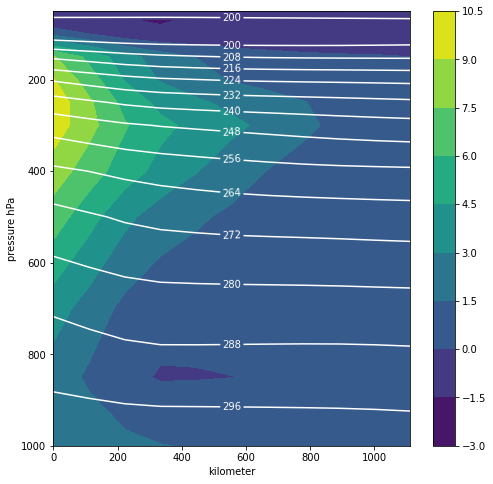

In [236]:
from metpy.constants import earth_avg_radius
from metpy.units import units

fig, ax = plt.subplots(figsize=[8, 8])
y = (earth_avg_radius).to(units.km) * (0.5*np.pi-plat)
p = ax.contourf(y, T.level, T_rotated_symmetric-T_rotated_symmetric[:,0][:, None])
c = ax.contour(y, T.level, T_rotated_symmetric, levels=15, colors=["white"])
ax.clabel(c)
ax.set_ylabel("pressure hPa")
ax.invert_yaxis()
fig.colorbar(p)
plt.show()

850 hPa気温の非軸対称成分を描きます。
軸対称成分からの偏差を計算し，経度方向を周期的になるように点を追加して，北極ポーラーステレオで描画します。

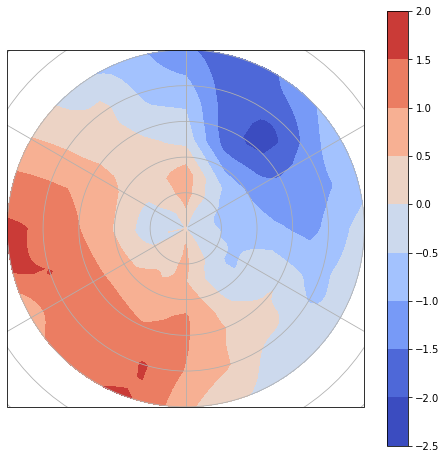

In [244]:
from cartopy.util import add_cyclic_point

T_rotated_asymmetric, lonc = add_cyclic_point(T_rotated-T_rotated_symmetric[:, :, None], np.rad2deg(plon))

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111, projection=ccrs.NorthPolarStereo())

p = ax.contourf(lonc, np.rad2deg(plat), T_rotated_asymmetric[2],
               transform=ccrs.PlateCarree(), cmap="coolwarm", vmin=-2.0, vmax=2.0)
ax.gridlines()
fig.colorbar(p)
plt.show()

台風の中心から離れたところでは，南西が暖かく，北東が冷たいことが分かります。
一方中心付近の気温偏差は小さいようです。